# Project Check-in 6

In [ ]:
# libraries for neural network

import torch
import torch.nn as nn
from  torch.optim import SGD
from torch.optim.lr_scheduler import LinearLR
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

In [ ]:
# Using the URL for the file
url = 'https://raw.githubusercontent.com/gengon7/CSM148-Data/refs/heads/main/StudentPerformanceFactors.csv'

# Read the CSV file from the URL
student_performance_factors = pd.read_csv(url)

student_performance_factors.head(5)
student_performance_factors.shape

(6607, 20)

The number of observations is 6607, so the batch size would be 16, 32, or 64.
This time we will use 32.

In [ ]:
num_cols = student_performance_factors.select_dtypes(include=np.number).columns
cat_cols = student_performance_factors.select_dtypes(exclude=np.number).columns


## Since a very small percentage of values are missing for these variables, we would not lose a significant amount of data by dropping the rows with missing values
miss_cat_cols = ["Teacher_Quality","Parental_Education_Level","Distance_from_Home"]
student_performance_factors = student_performance_factors.dropna(subset=miss_cat_cols)

In [ ]:
# encoding
Ordinal_cols = ["Parental_Involvement","Access_to_Resources","Motivation_Level","Family_Income","Teacher_Quality","Distance_from_Home", "Peer_Influence", "Parental_Education_Level"]
ord_enc = OrdinalEncoder(categories=[
    ["Low", "Medium", "High"],
    ["Low", "Medium", "High"],
    ["Low", "Medium", "High"],
    ["Low", "Medium", "High"],
    ["Low", "Medium", "High"],
    ["Near", "Moderate", "Far"],
    ["Negative", "Neutral", "Positive"],
    ["High School", "College", "Postgraduate"]
])

student_performance_factors[Ordinal_cols] = ord_enc.fit_transform(student_performance_factors[Ordinal_cols])

binary_cols = ["Extracurricular_Activities","Internet_Access","Learning_Disabilities","Gender","School_Type"]

for col in binary_cols:
    le = LabelEncoder()
    student_performance_factors[col] = le.fit_transform(student_performance_factors[col])

spf = student_performance_factors

student_performance_factors.head(5)

spf.head(5)

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,0.0,2.0,0,7,73,0.0,1,0,0.0,1.0,1,2.0,3,0,0.0,0.0,1,67
1,19,64,0.0,1.0,0,8,59,0.0,1,2,1.0,1.0,1,0.0,4,0,1.0,1.0,0,61
2,24,98,1.0,1.0,1,7,91,1.0,1,2,1.0,1.0,1,1.0,4,0,2.0,0.0,1,74
3,29,89,0.0,1.0,1,8,98,1.0,1,1,1.0,1.0,1,0.0,4,0,0.0,1.0,1,71
4,19,92,1.0,1.0,1,6,65,1.0,1,3,1.0,2.0,1,1.0,4,0,1.0,0.0,0,70


In [ ]:
# response variable is Exam_score

# we will implement prediction with neural network.

y = student_performance_factors["Exam_Score"]
#x = student_performance_factors.drop(columns=["Exam_Score"])
x = student_performance_factors[['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Previous_Scores', 'Tutoring_Sessions',
       'Family_Income', 'Peer_Influence', 'Parental_Education_Level']]

y = student_performance_factors["Exam_Score"].values.reshape(-1, 1)
# when you implement neural network, you want to scale features because when
# updating the weight, we use some type of gradient descent, which depends on the scale of the features.
# the larger the feature became, the more contribution the feature have on change by gradient descent, which
# leads to the difference among convergence of each weight.

scaler_x = StandardScaler()
scaler_y = StandardScaler()

x = scaler_x.fit_transform(x)
y = scaler_y.fit_transform(y).flatten()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Train the model
input_size = x_train.shape[1]
output_size = 1

model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, output_size)
)

#0.13804
optimizer = SGD(model.parameters(),lr = 0.00055)


epochs = 100
b_size =32
steps_per_epoch = len(x_train) // b_size

total_iters = len(x_train) // b_size * epochs

for epoch in range(epochs):
    idx = np.random.permutation(len(x_train))
    totalLoss = 0
    for step in range(steps_per_epoch):
        start_idx = step * b_size
        end_idx = start_idx + b_size

        x_batch = x_train[idx[start_idx:end_idx]]
        idxx = idx[start_idx:end_idx]

        y_batch = y_train[idx[start_idx:end_idx]]
        x_batch_tensor = torch.tensor(x_batch, dtype=torch.float32)
        y_batch_tensor = torch.tensor(y_batch, dtype=torch.float32).unsqueeze(1)  # Ensure shape (batch_size, 1)

        pred = model(x_batch_tensor)
        loss = nn.MSELoss()(pred, y_batch_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        totalLoss += loss.item()

        if (step + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Step {step + 1}, Loss: {loss.item():.4f}")
    print(f"Average Loss in Epoch {epoch + 1}: {totalLoss/steps_per_epoch}")
    print("-------------------------------------------------")

Epoch 1, Step 10, Loss: 0.6681
Epoch 1, Step 20, Loss: 2.0903
Epoch 1, Step 30, Loss: 1.1062
Epoch 1, Step 40, Loss: 1.0356
Epoch 1, Step 50, Loss: 1.2638
Epoch 1, Step 60, Loss: 1.1153
Epoch 1, Step 70, Loss: 0.6907
Epoch 1, Step 80, Loss: 0.6512
Epoch 1, Step 90, Loss: 0.5956
Epoch 1, Step 100, Loss: 0.9652
Epoch 1, Step 110, Loss: 1.5486
Epoch 1, Step 120, Loss: 0.6472
Epoch 1, Step 130, Loss: 0.7670
Epoch 1, Step 140, Loss: 0.5851
Epoch 1, Step 150, Loss: 0.9305
Average Loss in Epoch 1: 1.0026878883253854
-------------------------------------------------
Epoch 2, Step 10, Loss: 0.5904
Epoch 2, Step 20, Loss: 0.4295
Epoch 2, Step 30, Loss: 0.5812
Epoch 2, Step 40, Loss: 0.7682
Epoch 2, Step 50, Loss: 0.7648
Epoch 2, Step 60, Loss: 1.0783
Epoch 2, Step 70, Loss: 1.2544
Epoch 2, Step 80, Loss: 0.8453
Epoch 2, Step 90, Loss: 1.6380
Epoch 2, Step 100, Loss: 0.5814
Epoch 2, Step 110, Loss: 0.8625
Epoch 2, Step 120, Loss: 2.3027
Epoch 2, Step 130, Loss: 1.7016
Epoch 2, Step 140, Loss: 2.2

1. For this project check-in your team must demonstrate the application of a neural network (NN)) to
your project for classification or prediction.

The data set is relatively simple, so we implement a 3-layer neural network.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
input_size = x_train.shape[1]
output_size = 1

# Experiment with different learning rates using the method covered during lecture (initializing to a small value then multiplying by a multiplier)
model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, output_size)
)

initial_lr = 1e-5
optimizer = SGD(model.parameters(),lr = initial_lr)

batch_size = 32
num_iterations = 100
final_lr = 10**1
lr_multiplier = (final_lr / initial_lr) ** (1 / num_iterations)
print(f"Learning Rate Multiplier per Iteration: {lr_multiplier:.5f}")

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

lrs = []
losses = []

train_iter = iter(train_loader)

for iteration in range(1, num_iterations + 1):
    try:
        x_batch, y_batch = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x_batch, y_batch = next(train_iter)

    pred = model(x_batch)
    loss = nn.MSELoss()(pred, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    losses.append(loss.item())

    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item():.4f}, Learning Rate: {current_lr:.5f}")

    new_lr = current_lr * lr_multiplier
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr


Learning Rate Multiplier per Iteration: 1.14815
Iteration 10, Loss: 0.8786, Learning Rate: 0.00003
Iteration 20, Loss: 1.1266, Learning Rate: 0.00014
Iteration 30, Loss: 0.5637, Learning Rate: 0.00055
Iteration 40, Loss: 1.1198, Learning Rate: 0.00219
Iteration 50, Loss: 0.9239, Learning Rate: 0.00871
Iteration 60, Loss: 0.9143, Learning Rate: 0.03467
Iteration 70, Loss: 0.6175, Learning Rate: 0.13804
Iteration 80, Loss: 0.9570, Learning Rate: 0.54954
Iteration 90, Loss: 3192.7871, Learning Rate: 2.18776
Iteration 100, Loss: nan, Learning Rate: 8.70964


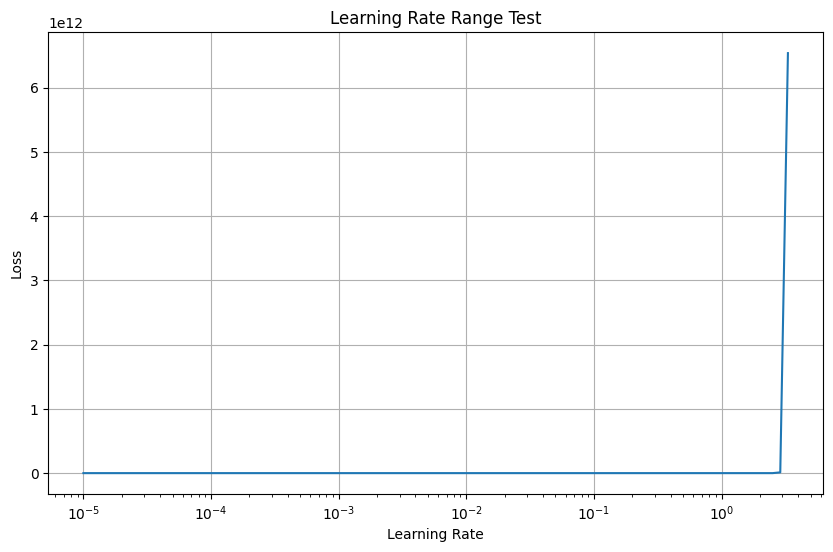

In [ ]:
# Plot Loss vs. Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate Range Test')
plt.grid(True)
plt.show()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
test_batch_size = 32


test_dataset = TensorDataset(
    torch.tensor(x_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# Get the predictions of the model
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        pred = model(x_batch)
        predictions.append(pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

y_pred = np.vstack(predictions).flatten()
y_true = np.vstack(actuals).flatten()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error

# Unscale y_pred and y_true
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_true_original = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()

# Calculate R-squared and MSE for the test set
rmse_test = np.sqrt(mean_squared_error(y_true_original, y_pred_original))
mae_test = mean_absolute_error(y_true_original, y_pred_original)
mad_test = median_absolute_error(y_true_original, y_pred_original)
r2_test = r2_score(y_true_original, y_pred_original)
corr_test = np.corrcoef(y_true_original, y_pred_original)[0, 1]  # Pearson correlation

# Print the results for the test set
print("\nTest Metrics:")
print(f"RMSE: {rmse_test}, MAE: {mae_test}, MAD: {mad_test}, Correlation: {corr_test}, R2: {r2_test}")


Test Metrics:
RMSE: 2.1947343349456787, MAE: 0.9101378917694092, MAD: 0.6199531555175781, Correlation: 0.830718669389917, R2: 0.6900213360786438


2. Please explain the metrics you are using to assess the performance of your NN

Our response variable is numerical variable, so the main metric we used is mean squared error. We saw the MSE loss while training the model, as we printed out the average loss for each epoch.

MSE = sum ( (y_true - y_pred)^2)

After the model was trained, we got the predictions from the model. Using the predictions and the true values, we then computed the MSE, rMSE, MAE, R2 score, and MAD. These are the typical metrics used for regression tasks.

3. Please also detail how you trained your NN including how you learned hyperparameters such as learning
rate.


First, we initially trained the model using a learning rate of 0.001. This did not work well for us, as the model was not converging. Then, we lowered the learning rate to 0.0001 to see if that would help by reducing oscillations, but the model still did not converge. Finally, we tried setting it to 0.002, which finally allowed it to converge. Trying these different learning rates and qualitatively looking at the metrics helped us to get a sense of the ideal learning rate, but a more robust method was to use the method we learned in lecture, which involved starting from 10^-5 to 10 in the end by multiplying the learning rate with a constant. After this, we made a plot of the loss vs. the learning rate to see which learning rate caused the loss to decrease before increasing sharply. Based on that, we settled on a learning rate of 0.13804, which had the best results in terms of getting the algorithm to converge at a relatively low loss (0.3).


4. Include code and explanation for the steps above in your notebook.